In [47]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.signal import resample
from librosa.display import specshow
import os
import benchmark
import utils


In [48]:
#getting all the saxophone wav audios files in an list : audio_files
type_wanted = "saxphone.wav"
directory = r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Bach10_v1.1"
audio_filespath =[]
audio_files_tuple = []
for root, dirs, files in os.walk(directory):
    for filename in files:
        #print(os.path.join(root, filename))
        if filename[len(filename)-len(type_wanted):len(filename)] == type_wanted :
            pathfile = os.path.join(root, filename)
            audio_filespath.append(pathfile)
            audio_files_tuple.append(wavfile.read(pathfile))
            


In [49]:
sample_rate = audio_files_tuple[0][0]
print(sample_rate)
new_sample_rate = 32000


44100


In [50]:
def info_about(sample_rate, audio ) : 
    res = { "max" : np.max(audio),
           "min" : np.min(audio),
           "format" : np.dtype(audio[0]),
           "taille" : len(audio),
           "durée [s]" : len(audio)/sample_rate
    }
    return res


In [51]:
#on met tout en float 64 pour les calculs
audio_files = []
for i in range(len(audio_files_tuple)):
    audio_files.append([audio_files_tuple[i][0], audio_files_tuple[i][1].astype(dtype = np.float64)])
    
print(len(audio_filespath))
print(audio_files)
print(info_about(audio_files[0][0], audio_files[0][1]))

10
[[44100, array([-308., -309., -302., ..., -266., -276., -271.])], [44100, array([-164., -159., -166., ..., -190., -200., -193.])], [44100, array([-217., -217., -220., ..., -150., -156., -149.])], [44100, array([-215., -214., -219., ..., -205., -207., -206.])], [44100, array([-232., -225., -225., ..., -194., -207., -196.])], [44100, array([-129., -134., -133., ..., -179., -181., -181.])], [44100, array([-199., -211., -202., ..., -255., -250., -245.])], [44100, array([-230., -237., -227., ..., -202., -199., -203.])], [44100, array([-226., -239., -248., ..., -271., -272., -277.])], [44100, array([-166., -184., -188., ...,  -68.,  -62.,  -71.])]]
{'max': 16047.0, 'min': -12720.0, 'format': dtype('float64'), 'taille': 1112495, 'durée [s]': 25.226643990929706}


In [52]:
#getting a wav file

filepath = r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Bach10_v1.1\01-AchGottundHerr\01-AchGottundHerr-bassoon.wav"

samplerate, audio = wavfile.read(filepath) #signal mono pour ce qui est de Bach10_v1.1 (un seul canal)

#img_1 = np.fft.fft(audio[0:128])
f, t, Sxx = spectrogram(audio, samplerate, nperseg = 512)



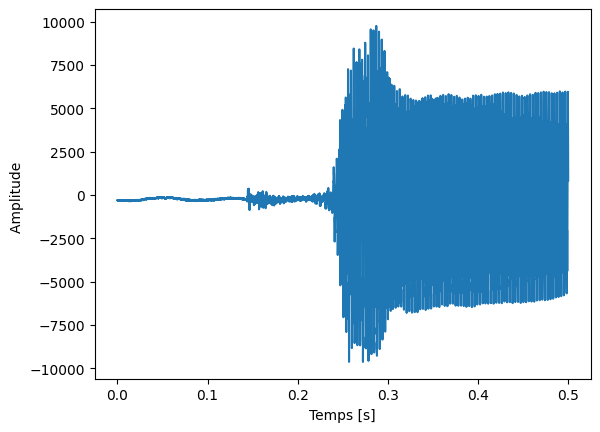

In [53]:
#VISUALISATION DU SIGNAL
audio_1 = audio_files[0][1]
t = np.linspace(0, len(audio_1)/audio_files[0][0], len(audio_1))
mask = t < 0.5
plt.plot(t[mask],audio_1[mask])
plt.xlabel("Temps [s]")
plt.ylabel("Amplitude ")
plt.show()

In [54]:
#Resampling du signal : 
audio_1 = resample(audio_1, int(len(audio_1)*new_sample_rate/sample_rate), t=t, window= "hamming", domain = "time")
audio_1, t = audio_1

In [55]:
temps_paquet = 0.01#0 #20ms
taille_paquet = int(temps_paquet *new_sample_rate) #nb_echantillons par paquet
print(taille_paquet)
num_paquet_choisi = 100
pos_sample = num_paquet_choisi*taille_paquet
paquet = audio_1[pos_sample:pos_sample + taille_paquet].copy()
np.dtype(paquet[0])

320


dtype('float64')

In [56]:
pos_loss = utils.los_generation(len(audio_1), taille_paquet, 100)
print(len(pos_loss), pos_loss)

AttributeError: module 'utils' has no attribute 'los_generation'

In [ ]:
#fonction pour silence et persistance
def filling_silence_persistance(audio, pos_gap, taille_paquet) :
    audio_persistance = audio.copy()
    audio_gap_filled = audio.copy()

    for x in pos_gap : 
        persistant = np.copy(audio[x-taille_paquet:x])

        audio_persistance[x:x+taille_paquet] = persistant
        audio_gap_filled[x:x+taille_paquet] = np.zeros(taille_paquet)
        
    return audio_gap_filled, audio_persistance

# Predictions avec différents modèles
### 1 seul audio

In [ ]:
print(taille_paquet)
import statsmodels.tsa.ar_model

320


In [ ]:
#BENCHMARK PREP
nmses1 = []
nmses_m1 = []
mels_cs1 = []
labels1 = []

In [ ]:
#Silence et Persistance
loss1, persistance1 = filling_silence_persistance(audio_1, pos_loss, taille_paquet)
nmse_silence_m, nmse_silence = benchmark.nmse_mean(audio_1, loss1, pos_loss, taille_paquet)
nmse_persistance_m, nmse_persistance = benchmark.nmse_mean(audio_1, persistance1, pos_loss, taille_paquet)
mel_cs_silence = benchmark.mel_cs(audio_1, loss1, new_sample_rate)
mel_cs_persistance = benchmark.mel_cs(audio_1, persistance1, new_sample_rate)
nmses1.append(nmse_silence)
nmses_m1.append(nmse_silence_m)
mels_cs1.append(mel_cs_silence)
labels1.append("0 Filling ")
nmses1.append(nmse_persistance)
nmses_m1.append(nmse_persistance_m)
mels_cs1.append(mel_cs_persistance)
labels1.append("Persistance")


In [ ]:
#AR 32
ar_32_1 = utils.audio_predictions(audio_1, pos_loss, taille_paquet, order=32, adapt = False)
nmse_AR_32_m, nmse_AR_32 = benchmark.nmse_mean(audio_1, ar_32_1, pos_loss, taille_paquet)
mel_cs_AR_32 = benchmark.mel_cs(audio_1, ar_32_1, new_sample_rate)
nmses1.append(nmse_AR_32)
nmses_m1.append(nmse_AR_32_m)
mels_cs1.append(mel_cs_AR_32)
labels1.append("AR 32")

In [ ]:
#AR 64
ar_64_1 = utils.audio_predictions(audio_1, pos_loss, taille_paquet, order=64, adapt = False)
nmse_AR_64_m, nmse_AR_64 = benchmark.nmse_mean(audio_1, ar_64_1, pos_loss, taille_paquet)
mel_cs_AR_64 = benchmark.mel_cs(audio_1, ar_64_1, new_sample_rate)
nmses1.append(nmse_AR_64)
nmses_m1.append(nmse_AR_64_m)
mels_cs1.append(mel_cs_AR_64)
labels1.append("AR 64")

In [ ]:
#AR 128
ar_128_1 = utils.audio_predictions(audio_1, pos_loss, taille_paquet, order=128, adapt = False)
nmse_AR_128_m, nmse_AR_128 = benchmark.nmse_mean(audio_1, ar_128_1, pos_loss, taille_paquet)
mel_cs_AR_128 = benchmark.mel_cs(audio_1, ar_128_1, new_sample_rate)
nmses1.append(nmse_AR_128)
nmses_m1.append(nmse_AR_128_m)
mels_cs1.append(mel_cs_AR_128)
labels1.append("AR 128")

In [ ]:
#AR 256
ar_256_1 = utils.audio_predictions(audio_1, pos_loss, taille_paquet, order=256, adapt = False)
nmse_AR_256_m, nmse_AR_256 = benchmark.nmse_mean(audio_1, ar_256_1, pos_loss, taille_paquet)
mel_cs_AR_256 = benchmark.mel_cs(audio_1, ar_256_1, new_sample_rate)
nmses1.append(nmse_AR_256)
nmses_m1.append(nmse_AR_256_m)
mels_cs1.append(mel_cs_AR_256)
labels1.append("AR 256")

In [ ]:
#AR ADAPTATIF
adapt_ar_128_1 = utils.audio_predictions(audio_1, pos_loss, taille_paquet, order=256, adapt = True)
nmse_our_AR_m, nmse_our_AR = benchmark.nmse_mean(audio_1, adapt_ar_128_1, pos_loss, taille_paquet)
mel_cs_our_AR = benchmark.mel_cs(audio_1, adapt_ar_128_1, new_sample_rate)
nmses1.append(nmse_our_AR)
nmses_m1.append(nmse_our_AR_m)
mels_cs1.append(mel_cs_our_AR)
labels1.append("Adaptative AR")

In [ ]:
# SAME WITH CROSSFADE
cross_adapt_ar_128_1 =utils.audio_predictions(audio_1, pos_loss, taille_paquet, order=256, crossfade_size= 0.1,adapt = True)
#NMSE is the same as Adaptative
mel_cs_crossfade_adapt = benchmark.mel_cs(audio_1, cross_adapt_ar_128_1, new_sample_rate)
mels_cs1.append(mel_cs_crossfade_adapt)

In [ ]:
#PERSISTANCE FREQUENTIELLE
freq_persistance1 = utils.freq_persistance(audio_1, pos_loss, taille_paquet, sample_rate=new_sample_rate)
nmse_freq_pers_m, nmse_freq_pers = benchmark.nmse_mean(audio_1, freq_persistance1, pos_loss, taille_paquet)
mel_freq_pers = benchmark.mel_cs(audio_1, freq_persistance1, new_sample_rate)
nmses1.append(nmse_freq_pers)
nmses_m1.append(nmse_freq_pers_m)
mels_cs1.append(mel_freq_pers)
labels1.append("Persistance Freq")

# Benchmark et analyse des résultats 

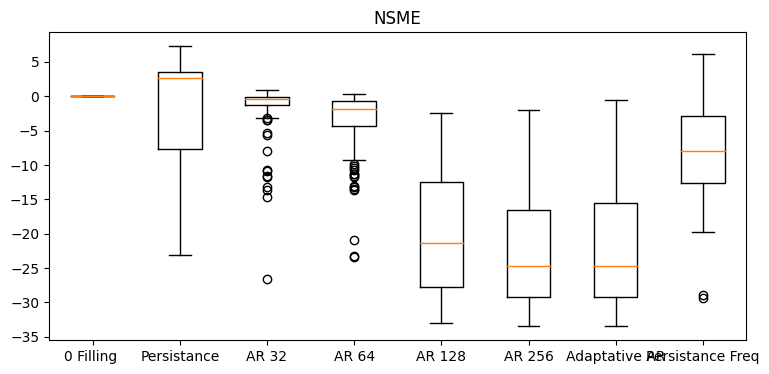

In [ ]:
fig, axes = plt.subplots(nrows = 1, figsize = (9,4))
axes.boxplot(nmses1, labels= labels1)
axes.set_title("NSME")
plt.show()

In [ ]:
for i in range(len(nmses_m1)) :
    print(f"Pour la méthode de {labels1[i]} : NMSES = {nmses_m1[i]} et MEL_CS = {mels_cs1[i]}")

Pour la méthode de 0 Filling  : NMSES = 0.0 et MEL_CS = 0.20521147882360213
Pour la méthode de Persistance : NMSES = -1.7852667632732322 et MEL_CS = 0.09999369146865711
Pour la méthode de AR 32 : NMSES = -1.8326479759086558 et MEL_CS = 0.1775436096191278
Pour la méthode de AR 64 : NMSES = -3.8485681586201044 et MEL_CS = 0.14589385307180924
Pour la méthode de AR 128 : NMSES = -19.96232611533625 et MEL_CS = 0.03870675842674903
Pour la méthode de AR 256 : NMSES = -22.5032232505998 et MEL_CS = 0.026748612274898106
Pour la méthode de Adaptative AR : NMSES = -22.20897235731244 et MEL_CS = 0.04754361961331604
Pour la méthode de Persistance Freq : NMSES = -8.020753119920922 et MEL_CS = 0.04754361961331604


Pour la méthode de 0 Filling  : NMSES = 0.0 et MEL_CS = 0.20789415364887687
Pour la méthode de Persistance : NMSES = -1.189484583564226 et MEL_CS = 0.11382224913547186
Pour la méthode de AR 32 : NMSES = -1.9907357630478864 et MEL_CS = 0.15845660634377262
Pour la méthode de AR 64 : NMSES = -4.018231386544352 et MEL_CS = 0.13313400205597872
Pour la méthode de AR 128 : NMSES = -20.901692734099207 et MEL_CS = 0.0256970219648695
Pour la méthode de AR 256 : NMSES = -22.682744510998756 et MEL_CS = 0.12595900815757619
Pour la méthode de Adaptative AR : NMSES = -20.714365042009522 et MEL_CS = 0.028236992909806358
Pour la méthode de Persistance Freq : NMSES = -7.615510521917278 et MEL_CS = 0.028236992909806358

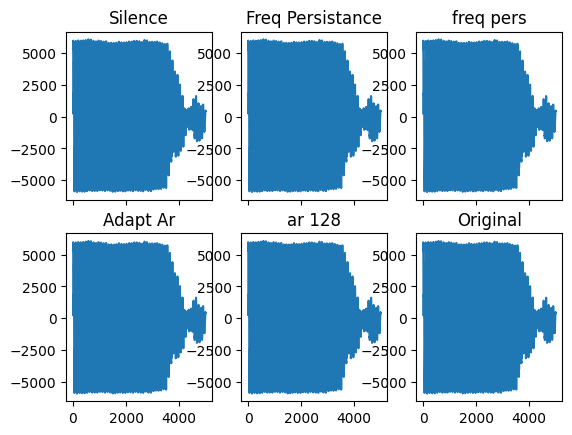

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, sharex=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
ax1.plot(loss1[20000:25000], label = "Silence")
ax1.set_title("Silence")
ax2.plot(persistance1[20000:25000], label = "Presistance")
ax2.set_title("Freq Persistance")
ax3.plot(freq_persistance1[20000:25000], label = "freq pers")
ax3.set_title("freq pers")
ax4.plot(adapt_ar_128_1[20000:25000], label = "Adapt Ar")
ax4.set_title("Adapt Ar")
ax5.plot(ar_128_1[20000:25000], label = "ar 128")
ax5.set_title("ar 128")
ax6.plot(audio_1[20000:25000], label = "Original")
ax6.set_title("Original")
plt.show()

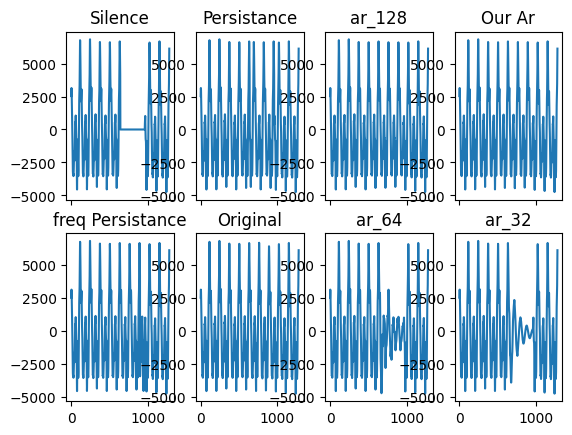

In [ ]:
trou = pos_loss[12]#np.argmax(audio_AR_128)#pos_loss[10]
dec = 2
fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()
ax1.plot(loss1[trou - dec*len(paquet):trou + dec*len(paquet)], label = "Silence")
ax1.set_title("Silence")
ax2.plot(persistance1[trou - dec*len(paquet) :trou + dec*len(paquet)], label = "Presistance")
ax2.set_title("Persistance")
ax3.plot(ar_128_1[trou - dec*len(paquet) :trou + dec*len(paquet)], label = "ar")
ax3.set_title("ar_128")
ax4.plot(adapt_ar_128_1[trou - dec*len(paquet) :trou + dec*len(paquet)], label = "Our Ar")
ax4.set_title("Our Ar")
ax5.plot(freq_persistance1[trou - dec*len(paquet) :trou + dec*len(paquet)], label = "freq Persistance")
ax5.set_title("freq Persistance")
ax6.plot(audio_1[trou - dec*len(paquet) :trou + dec*len(paquet)], label = "Original")
ax6.set_title("Original")
ax7.plot(ar_64_1[trou - dec*len(paquet) :trou + dec*len(paquet)], label = "Original")
ax7.set_title("ar_64")
ax8.plot(ar_32_1[trou - dec*len(paquet) :trou + dec*len(paquet)], label = "Original")
ax8.set_title("ar_32")
plt.show()

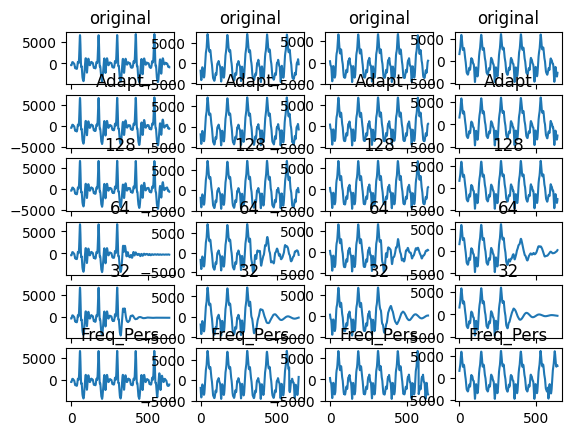

In [ ]:
trou = pos_loss[10:40]
fig, axes = plt.subplots(nrows = 6, ncols = 4, sharex=True)
axs = axes.flatten()
for i in range(4):
    axs[i].plot(audio_1[trou[i]-taille_paquet: trou[i]+taille_paquet], label = f"Original")
    axs[i].set_title(f"original")
for i in range(4,8) :
    axs[i].plot(adapt_ar_128_1[trou[i-4]-taille_paquet: trou[i-4]+taille_paquet], label = f"trou num {i}")
    axs[i].set_title(f"Adapt")
for i in range(8,12):
    axs[i].plot(ar_128_1[trou[i-8]-taille_paquet: trou[i-8]+taille_paquet], label = f"trou num {i}")
    axs[i].set_title(f"128")
for i in range(12,16) : 
    axs[i].plot(ar_64_1[trou[i-12]-taille_paquet: trou[i-12]+taille_paquet], label = f"trou num {i}")
    axs[i].set_title(f"64")
for i in range(16,20) : 
    axs[i].plot(ar_32_1[trou[i-16]-taille_paquet: trou[i-16]+taille_paquet], label = f"trou num {i}")
    axs[i].set_title(f"32")
for i in range(20,24):
    axs[i].plot(freq_persistance1[trou[i-20]-taille_paquet: trou[i-20]+taille_paquet], label = f"trou num {i}")
    axs[i].set_title(f"Freq_Pers")
plt.show()

# Enregistrement des fichiers produits 

In [ ]:
directory = "produced_audio"
utils.write_wav(loss1, new_sample_rate, "Silence_filling", directory=directory)
utils.write_wav(persistance1, new_sample_rate, "Persistance", directory=directory)
utils.write_wav(ar_128_1, new_sample_rate, "ar_128", directory=directory)
utils.write_wav(ar_256_1, new_sample_rate, "ar_256", directory=directory)
utils.write_wav(adapt_ar_128_1, new_sample_rate, "Adapt_128", directory=directory)
utils.write_wav(cross_adapt_ar_128_1, new_sample_rate, "adapt_128_crossfade", directory=directory)
utils.write_wav(freq_persistance1, new_sample_rate, "Persistance Fréquentielle ", directory=directory)
utils.write_wav(audio_1, new_sample_rate, "audio_original", directory=directory)


In [ ]:
#RESAMPLING FOR PEAQ
peaq_sr  = 48000
directory = "peaq_test"
utils.write_wav(audio_1, samplerate=new_sample_rate, name = "original_peaq", new_samplerate=peaq_sr, directory = directory)
utils.write_wav(adapt_ar_128_1, samplerate=new_sample_rate, name = "adapt_AR_peaq", new_samplerate=peaq_sr, directory = directory)
utils.write_wav(ar_128_1, samplerate=new_sample_rate, name = "AR_128_peaq", new_samplerate=peaq_sr,  directory = directory)
utils.write_wav(loss1, samplerate=new_sample_rate, name = "silence_peaq", new_samplerate=peaq_sr, directory = directory)
utils.write_wav(cross_adapt_ar_128_1, samplerate=new_sample_rate, name = "crossfaded_peaq", new_samplerate=peaq_sr, directory = directory)
utils.write_wav(freq_persistance1, samplerate = new_sample_rate, name = "freq_persistance", new_samplerate=peaq_sr, directory = directory)

#pour 49 trous de 10ms : 

#peaq(original, ar_128) = -3.5497
#peaq(original, adapt_AR) =-2.2700
#peaq(original, silence) = -3.6564
#peaq(original, crossfade) = -3.9124

# Pour les 10 audios de saxophone maintenant :

In [ ]:
print(len(np.array(audio_files)[:,1]))

10


C:\Users\hippo\AppData\Local\Temp\ipykernel_27916\3126355271.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(len(np.array(audio_files)[:,1]))


In [ ]:
pos_gap = np.array([], dtype=np.int32)
conc_audio = []
list_audio = np.array(audio_files)[:,1]
for audio in  list_audio: 
    #CREATIONS LOSS ALEATOIRES : 
    loss_audio = utils.los_generation(len(audio), taille_paquet, n_loss = 100) + len(conc_audio)
    pos_gap = np.concatenate((pos_gap, loss_audio))
    resampled_audio = resample(audio, int(len(audio)*new_sample_rate/sample_rate), window= "hamming", domain = "time")
    conc_audio = np.concatenate((conc_audio, resampled_audio))

C:\Users\hippo\AppData\Local\Temp\ipykernel_27916\1667963057.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list_audio = np.array(audio_files)[:,1]


In [ ]:
print(len(pos_gap))

965


In [ ]:
#BENCHMARK PREP
nmses = []
nmses_m = []
mels_cs = []
labels = []

In [ ]:
#Silence et Persistance
loss, persistance = filling_silence_persistance(conc_audio, pos_gap, taille_paquet)
nmse_silence_m, nmse_silence = benchmark.nmse_mean(conc_audio, loss, pos_gap, taille_paquet)
nmse_persistance_m, nmse_persistance = benchmark.nmse_mean(conc_audio, persistance, pos_gap, taille_paquet)
mel_cs_silence = benchmark.mel_cs(conc_audio, loss, new_sample_rate)
mel_cs_persistance = benchmark.mel_cs(conc_audio, persistance, new_sample_rate)
nmses.append(nmse_silence)
nmses_m.append(nmse_silence_m)
mels_cs.append(mel_cs_silence)
labels.append("0 Filling ")
nmses.append(nmse_persistance)
nmses_m.append(nmse_persistance_m)
mels_cs.append(mel_cs_persistance)
labels.append("Persistance")


In [ ]:
#AR 32
ar_32 = utils.audio_predictions(conc_audio, pos_gap, taille_paquet, order=32, adapt = False)
nmse_AR_32_m, nmse_AR_32 = benchmark.nmse_mean(conc_audio, ar_32, pos_gap, taille_paquet)
mel_cs_AR_32 = benchmark.mel_cs(conc_audio, ar_32, new_sample_rate)
nmses.append(nmse_AR_32)
nmses_m.append(nmse_AR_32_m)
mels_cs.append(mel_cs_AR_32)
labels.append("AR 32")

In [ ]:
#AR 64
ar_64 = utils.audio_predictions(conc_audio, pos_gap, taille_paquet, order=64, adapt = False)
nmse_AR_64_m, nmse_AR_64 = benchmark.nmse_mean(conc_audio, ar_64, pos_gap, taille_paquet)
mel_cs_AR_64 = benchmark.mel_cs(conc_audio, ar_64, new_sample_rate)
nmses.append(nmse_AR_64)
nmses_m.append(nmse_AR_64_m)
mels_cs.append(mel_cs_AR_64)
labels.append("AR 64")

In [ ]:
#AR 128
ar_128 = utils.audio_predictions(conc_audio, pos_gap, taille_paquet, order=128, adapt = False)
nmse_AR_128_m, nmse_AR_128 = benchmark.nmse_mean(conc_audio, ar_128, pos_gap, taille_paquet)
mel_cs_AR_128 = benchmark.mel_cs(conc_audio, ar_128, new_sample_rate)
nmses.append(nmse_AR_128)
nmses_m.append(nmse_AR_128_m)
mels_cs.append(mel_cs_AR_128)
labels.append("AR 128")

In [ ]:
#AR 256
ar_256 = utils.audio_predictions(conc_audio, pos_gap, taille_paquet, order=256, adapt = False)
nmse_AR_256_m, nmse_AR_256 = benchmark.nmse_mean(conc_audio, ar_256, pos_gap, taille_paquet)
mel_cs_AR_256 = benchmark.mel_cs(conc_audio, ar_256, new_sample_rate)
nmses.append(nmse_AR_256)
nmses_m.append(nmse_AR_256_m)
mels_cs.append(mel_cs_AR_256)
labels.append("AR 256")

In [ ]:
#AR ADAPTATIF
adapt_ar_128 = utils.audio_predictions(conc_audio, pos_gap, taille_paquet, order=256, adapt = True)
nmse_our_AR_m, nmse_our_AR = benchmark.nmse_mean(conc_audio, adapt_ar_128, pos_gap, taille_paquet)
mel_cs_our_AR = benchmark.mel_cs(conc_audio, adapt_ar_128, new_sample_rate)
nmses.append(nmse_our_AR)
nmses_m.append(nmse_our_AR_m)
mels_cs.append(mel_cs_our_AR)
labels.append("Adaptative AR")

In [ ]:
# SAME WITH CROSSFADE
cross_adapt_ar_128 =utils.audio_predictions(conc_audio, pos_gap, taille_paquet, order=128, crossfade_size= 0.1,adapt = True)
#NMSE is the same as Adaptative
mel_cs_crossfade_adapt = benchmark.mel_cs(conc_audio, cross_adapt_ar_128, new_sample_rate)
mels_cs.append(mel_cs_crossfade_adapt)

In [ ]:
#PERSISTANCE FREQUENTIELLE
freq_persistance = utils.freq_persistance(conc_audio, pos_gap, taille_paquet, sample_rate=new_sample_rate)
nmse_freq_pers_m, nmse_freq_pers = benchmark.nmse_mean(conc_audio, freq_persistance, pos_gap, taille_paquet)
mel_freq_pers = benchmark.mel_cs(conc_audio, freq_persistance, new_sample_rate)
nmses.append(nmse_freq_pers)
nmses_m.append(nmse_freq_pers_m)
mels_cs.append(mel_freq_pers)
labels.append("Persistance Freq")


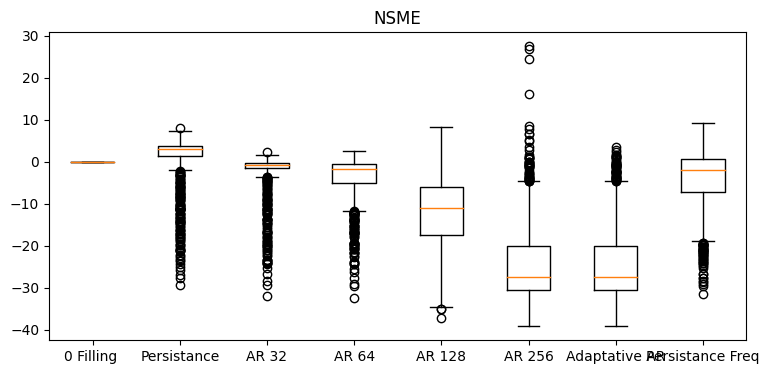

In [ ]:
fig, axes = plt.subplots(nrows = 1, figsize = (9,4))
axes.boxplot(nmses, labels= labels)
axes.set_title("NSME")
plt.show()

In [ ]:
for i in range(len(nmses_m)) :
    print(f"Pour la méthode de {labels[i]} : NMSES = {nmses_m[i]} et MEL_CS = {mels_cs[i]}")

Pour la méthode de 0 Filling  : NMSES = 0.0 et MEL_CS = 0.13556433813903787
Pour la méthode de Persistance : NMSES = 1.0968062865588308 et MEL_CS = 0.09725688259793897
Pour la méthode de AR 32 : NMSES = -2.1973021854108676 et MEL_CS = 0.12038889858485198
Pour la méthode de AR 64 : NMSES = -3.7436523614411406 et MEL_CS = 0.09505979427965038
Pour la méthode de AR 128 : NMSES = -12.374715879857833 et MEL_CS = 0.042796043465343055
Pour la méthode de AR 256 : NMSES = -24.124658119320973 et MEL_CS = 0.740132875907177
Pour la méthode de Adaptative AR : NMSES = -24.251353985085274 et MEL_CS = 0.018295301577373895
Pour la méthode de Persistance Freq : NMSES = -4.217436174353409 et MEL_CS = 0.03432455303125149


Pour le saxophone : 
AR adaptatif : 
NMSE : -11.16
MEL_CS = 0.04732417066318398
Pour la clarinette : 
AR adaptatif : 
NMSE : -22.966604809570565 
MEL_CS notre AR = 0.006606471373709898 
Pour le violon : 
NMSE = -14.439835091112068 
MEL_CS = 0.015349575703658407 
Pour le Basson : 
NMSE = -2.6595652157020253 
MEL_CS = 0.28884949257434434 

(256, 1576)


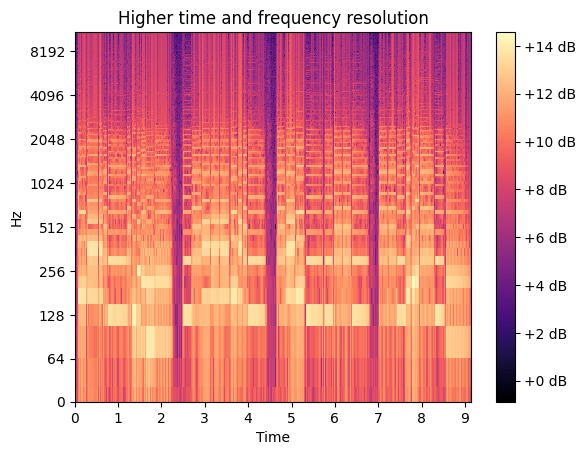

In [ ]:
t,f,sfft = utils.spectrogram(audio_1)
print(np.array(sfft).shape)
fig, ax = plt.subplots()
#D_highres = librosa.stft(y, hop_length=256, n_fft=4096)
#S_db_hr = librosa.amplitude_to_db(np.abs(D_highres), ref=np.max)
img = specshow(sfft, hop_length=512//4, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Higher time and frequency resolution')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

(257, 2101)


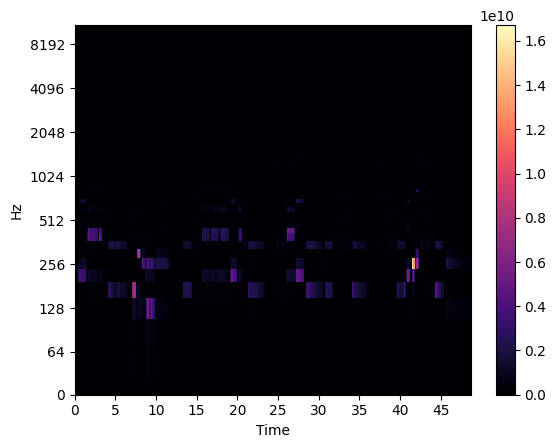

In [ ]:
test = spectrogram(audio_1, nperseg = 512, nfft = 512, noverlap = 512//4 )
print(test[2].shape)
specshow(test[2], x_axis='time', y_axis='log')
plt.colorbar()
plt.show()


In [ ]:
#quand est-ce qu'en troncant avec fourier on commence à l'entendre ? 
#regarder avec peaq quelle est la limite de troncature
# étude de fourier découpé dans le temps, et nombre fini de coefficient ? 
#similaire aux algos finis de compression' 
# chercher dans fourier, 
# prendre en compte les harmoniques de l'instrument
# ce qui est intéressant : le rythme de la percusion qui se décompose dans fourier, 
#pour les percussions : trouver le moment ou il se joue
# stratégie différenciées selon les instruments

